# Problem 2

In [126]:
# imports
import numpy as np
from matplotlib import pyplot as plt
import copy
from tabulate import tabulate
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## 2.1 GMM

###  Implement GMM in a class which has the routines to fit data

In [127]:
csv_data = pd.read_csv('q2-resources/SMAI-Dataset-customer-dataset/data.csv')
csv_data

,Index,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,0,67,2,124670,1,2
1,1,1,1,22,1,150773,1,2
2,2,0,0,49,1,89210,0,0
3,3,0,0,45,1,171565,1,1
4,4,0,0,53,1,149031,1,1
...,...,...,...,...,...,...,...,...
1995,1995,1,0,47,1,123525,0,0
1996,1996,1,1,27,1,117744,1,0
1997,1997,0,0,31,0,86400,0,0
1998,1998,1,1,24,1,97968,0,0


In [128]:
# dropping index attribute as it shouldn't affect clustering
csv_data = csv_data.drop('Index', axis=1)
csv_data

,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,67,2,124670,1,2
1,1,1,22,1,150773,1,2
2,0,0,49,1,89210,0,0
3,0,0,45,1,171565,1,1
4,0,0,53,1,149031,1,1
...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0
1996,1,1,27,1,117744,1,0
1997,0,0,31,0,86400,0,0
1998,1,1,24,1,97968,0,0


In [129]:
# converting to numpy array
data = csv_data.values
# normalizing data
scaler = StandardScaler()
data = scaler.fit_transform(data)
data[0]

array([-0.91739884, -0.99302433,  2.65361447,  1.60432297,  0.09752361,
        0.29682303,  1.552326  ])

In [130]:
data.shape

(2000, 7)

In [131]:
class GMM:
    '''
        Function to return gaussian function value
    '''
    def gauss(self, sample, mean, cov):
        
        n = len(sample)

        denom = (2*np.pi)**(n/2) * np.linalg.det(cov)**(1/2)
        exp_term = -1/2 * (sample - mean).T @ np.linalg.inv(cov) @ (sample - mean)

        return np.exp(exp_term)/denom
    
    
    '''
        Function to initialize mixing coefficients, means and variances
    '''
    def param_init(self):
        phis = np.full(self.num_clusters, 1/self.num_clusters)
        means = np.random.rand(self.num_clusters, self.data_dim)
        # covs = np.full(self.num_clusters, np.identity(self.data_dim))
        covs = np.array([np.identity(self.data_dim) for i in range(self.num_clusters)])
        
        return phis, means, covs
    
    
    '''
        Function for initializing GMM
    '''    
    def __init__(self, data, num_clusters = 5):
        self.data = data
        self.num_clusters = num_clusters
        
        self.num_samples, self.data_dim = data.shape
        
        # random initialzation
        self.phis, self.means, self.covs = self.param_init()
        
        
    '''
        Function to run Expectation step (calculating membership values, r_ik
    '''
    def E_step(self):
        membership_values = np.full((self.num_samples, self.num_clusters), 0.)
        for i in range(self.num_samples):
            for k in range(self.num_clusters):
                membership_values[i][k] = self.phis[k] * self.gauss(self.data[i], self.means[k], self.covs[k])

        row_sums = membership_values.sum(axis=1) # normalizing rows - taken from https://stackoverflow.com/questions/8904694/how-to-normalize-a-2-dimensional-numpy-array-in-python-less-verbose
        self.membership_values = membership_values / row_sums[:, np.newaxis]
    
    
    '''
        Function to run Maximization step
    '''
    def M_step(self):
        column_sums = self.membership_values.sum(axis=0)
        
        for k in range(self.num_clusters):
            # calculating phis
            self.phis[k] = column_sums[k]/self.num_samples
            
            # calculating means
            self.means[k] = np.zeros(self.data_dim)
            for i in range(self.num_samples):
                self.means[k] += self.membership_values[i][k] * self.data[i]
            self.means[k] /= column_sums[k]
            
            # calculating covs
            self.covs[k] = np.zeros((self.data_dim, self.data_dim))
            
            for i in range(self.num_samples):
                cur_column_vector = (self.data[i] - self.means[k])[:, np.newaxis] # converting to column vector
                cur_prod = cur_column_vector @ cur_column_vector.T
                self.covs[k] += self.membership_values[i][k] * cur_prod
            
            self.covs[k] /= column_sums[k]

            self.covs[k] += 1e-6*np.identity(self.data_dim) # to prevent singular matrix due to precision errors
            
            
    '''
        Function to run the GMM implementation (fitting data)
    '''
    def run(self, num_iters = 400, print_like = False, threshold = 1e-6):
        self.num_iters = num_iters
        old_likelihood = None
        for i in range(num_iters):
            self.E_step()
            self.M_step()
            if print_like:
                print("Iteration {}: {}".format(i+1, self.get_likelihoods()))
            
            cur_likelihood = self.get_likelihoods()
            if old_likelihood is not None:
                diff = cur_likelihood - old_likelihood
                if (diff <= threshold):
                    break
            old_likelihood = cur_likelihood
            
            
        return self.phis, self.means, self.covs
    
    
    '''
        Function to get parameters
    '''
    def get_params(self):
        return {
            'num_iters': self.num_iters,
            'num_clusters': self.num_clusters,
            'num_samples': self.num_samples,
            'means': self.means,
            'covs': self.covs,
            'phis': self.phis
        }
    
    '''
        Function to calculate likelihoods for a given set of samples
    '''
    def get_likelihoods(self, sample_list = None):
        if sample_list is None:
            sample_list = self.data
            
        likelihood = 0
        for sample in sample_list:
            cur_sum = 0
            for k in range(self.num_clusters):
                cur_sum += self.gauss(sample, self.means[k], self.covs[k])*self.phis[k]
            likelihood += np.log(cur_sum)
        return likelihood
    
    '''
        Function to return membership values
    '''
    def get_membership(self):
        return self.membership_values

In [132]:
# some dummy data for checking correctness - asked chatGPT for dummy bivariate distribution
'''
np.random.seed(0)
mean1 = np.array([2, 3])
cov1 = np.array([[1, 0.5], [0.5, 1]])
mean2 = np.array([-2, -1])
cov2 = np.array([[1, -0.8], [-0.8, 1]])
data1 = np.random.multivariate_normal(mean1, cov1, 500)
data2 = np.random.multivariate_normal(mean2, cov2, 500)
data = np.vstack((data1, data2))
data
'''

'\nnp.random.seed(0)\nmean1 = np.array([2, 3])\ncov1 = np.array([[1, 0.5], [0.5, 1]])\nmean2 = np.array([-2, -1])\ncov2 = np.array([[1, -0.8], [-0.8, 1]])\ndata1 = np.random.multivariate_normal(mean1, cov1, 500)\ndata2 = np.random.multivariate_normal(mean2, cov2, 500)\ndata = np.vstack((data1, data2))\ndata\n'

In [133]:
my_gmm = GMM(data, num_clusters=2)
phis, means, covs = my_gmm.run(print_like = True)

print(means[0])
print(means[1])
print(my_gmm.phis)
print(my_gmm.get_likelihoods())

Iteration 1: -16768.66900727889
Iteration 2: -16610.49208772243
Iteration 3: -16441.576462737663
Iteration 4: -16058.792516307232
Iteration 5: -15187.395822954155
Iteration 6: -7618.56512573564
Iteration 7: -6343.0921366034345
Iteration 8: -4036.4579795022446
Iteration 9: -4036.4548224512764
Iteration 10: -4036.4548224512764
[ 0.0266739  -0.0524262   0.0345989  -0.04312564  0.05981755  0.04660762
  0.05700091]
[-0.09596473  0.18861382 -0.12447649  0.15515318 -0.21520567 -0.1676803
 -0.20507224]
[0.7825 0.2175]
-4036.4548224512764


In [134]:
# demonstrating other functionalities
my_gmm.get_params()

{'num_iters': 400,
 'num_clusters': 2,
 'num_samples': 2000,
 'means': array([[ 0.0266739 , -0.0524262 ,  0.0345989 , -0.04312564,  0.05981755,
          0.04660762,  0.05700091],
        [-0.09596473,  0.18861382, -0.12447649,  0.15515318, -0.21520567,
         -0.1676803 , -0.20507224]]),
 'covs': array([[[ 1.00389448,  1.00019869, -0.251515  ,  0.3937445 ,
          -0.16828246, -0.14552017, -0.25104249],
         [ 1.00019869,  0.99651851, -0.25058931,  0.39229534,
          -0.1676631 , -0.14498459, -0.25011854],
         [-0.251515  , -0.25058931,  1.05542373,  0.69932153,
           0.36448665,  0.13954728,  0.14223677],
         [ 0.3937445 ,  0.39229534,  0.69932153,  1.03565767,
           0.21179067,  0.0434561 , -0.01170233],
         [-0.16828246, -0.1676631 ,  0.36448665,  0.21179067,
           1.0286317 ,  0.67756631,  0.50007013],
         [-0.14552017, -0.14498459,  0.13954728,  0.0434561 ,
           0.67756631,  0.98461552,  0.57825098],
         [-0.25104249, -0.25

In [135]:
my_gmm.get_likelihoods()

-4036.4548224512764

In [136]:
my_gmm.get_membership()

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [137]:
max_clusters = 30

likelihoods = []
for num_clusters in range(1, max_clusters+1):
    print("--{}--".format(num_clusters), end = " ")

    my_gmm = GMM(data, num_clusters=num_clusters)
    my_gmm.run()
    
    likelihoods.append(my_gmm.get_likelihoods())

--1-- --2-- --3-- --4-- --5-- --6-- --7-- --8-- --9-- --10-- --11-- --12-- --13-- --14-- --15-- --16-- --17-- --18-- --19-- --20-- --21-- --22-- --23-- --24-- --25-- --26-- --27-- --28-- --29-- --30-- 

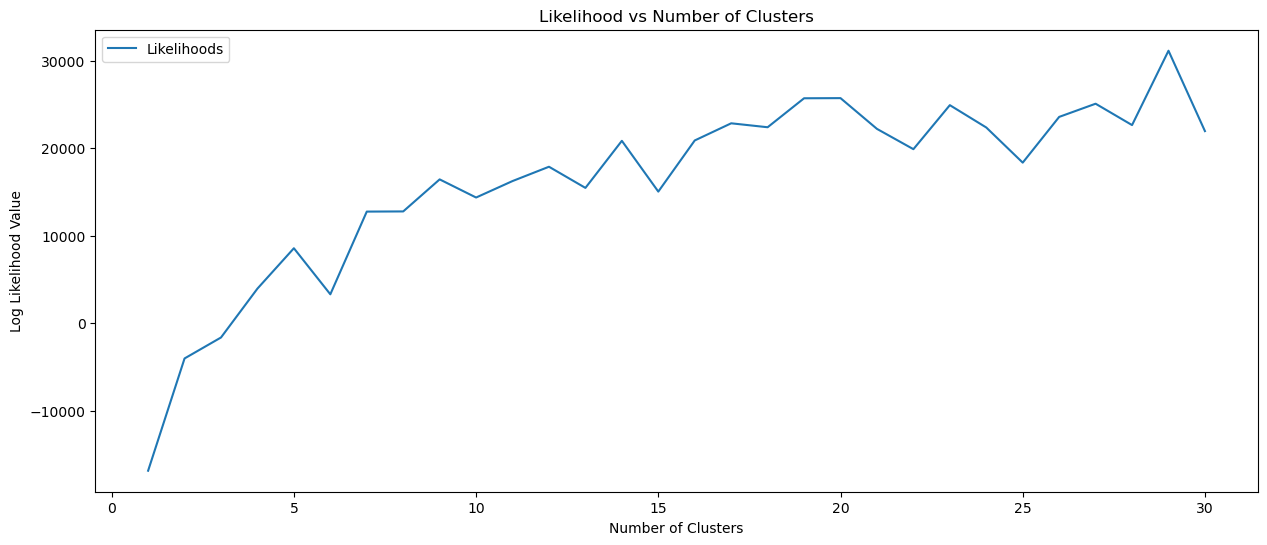

In [138]:
plt.figure(figsize=(15, 6))

plt.plot(np.arange(1, max_clusters+1), likelihoods, label='Likelihoods')

plt.xlabel('Number of Clusters')
plt.ylabel('Log Likelihood Value')
plt.title('Likelihood vs Number of Clusters')
plt.legend()

plt.show()

#### Observations on varying number of components
- The log likelihood increases with an increase in the number of clusters
- This can be attributed to the model being more sure of which cluster a data point is associated with

### Perform clustering on the wine-dataset using Gaussian Mixture Model (GMM) and K-Means algorithms

In [12]:
from sklearn.datasets import load_wine
data = load_wine()

In [13]:
print(data.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

In [14]:
data.data.shape

(178, 13)

In [15]:
wine_data = data.data
wine_data

array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
        1.065e+03],
       [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
        1.050e+03],
       [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
        1.185e+03],
       ...,
       [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
        8.350e+02],
       [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
        8.400e+02],
       [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
        5.600e+02]])

In [16]:
# normalizing data
scaler = StandardScaler()
wine_data = scaler.fit_transform(wine_data)
wine_data

array([[ 1.51861254, -0.5622498 ,  0.23205254, ...,  0.36217728,
         1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, ...,  0.40605066,
         1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, ...,  0.31830389,
         0.78858745,  1.39514818],
       ...,
       [ 0.33275817,  1.74474449, -0.38935541, ..., -1.61212515,
        -1.48544548,  0.28057537],
       [ 0.20923168,  0.22769377,  0.01273209, ..., -1.56825176,
        -1.40069891,  0.29649784],
       [ 1.39508604,  1.58316512,  1.36520822, ..., -1.52437837,
        -1.42894777, -0.59516041]])

In [17]:
# PCA
pca = PCA(n_components=2)
pca.fit(wine_data)
wine_data = pca.transform(wine_data)
wine_data

array([[ 3.31675081, -1.44346263],
       [ 2.20946492,  0.33339289],
       [ 2.51674015, -1.0311513 ],
       [ 3.75706561, -2.75637191],
       [ 1.00890849, -0.86983082],
       [ 3.05025392, -2.12240111],
       [ 2.44908967, -1.17485013],
       [ 2.05943687, -1.60896307],
       [ 2.5108743 , -0.91807096],
       [ 2.75362819, -0.78943767],
       [ 3.47973668, -1.30233324],
       [ 1.7547529 , -0.61197723],
       [ 2.11346234, -0.67570634],
       [ 3.45815682, -1.13062988],
       [ 4.31278391, -2.09597558],
       [ 2.3051882 , -1.66255173],
       [ 2.17195527, -2.32730534],
       [ 1.89897118, -1.63136888],
       [ 3.54198508, -2.51834367],
       [ 2.0845222 , -1.06113799],
       [ 3.12440254, -0.78689711],
       [ 1.08657007, -0.24174355],
       [ 2.53522408,  0.09184062],
       [ 1.64498834,  0.51627893],
       [ 1.76157587,  0.31714893],
       [ 0.9900791 , -0.94066734],
       [ 1.77527763, -0.68617513],
       [ 1.23542396,  0.08980704],
       [ 2.18840633,

In [18]:
max_clusters = 100

In [19]:
# running winedata over multiple number of clusters
gmm_implementations = [None]
for num_clusters in range(1, max_clusters+1):
    print("--{}--".format(num_clusters), end = " ")
    my_gmm = GMM(wine_data, num_clusters=num_clusters)
    my_gmm.run()
    
    gmm_implementations.append(my_gmm)

--1-- --2-- --3-- --4-- --5-- --6-- --7-- --8-- --9-- --10-- --11-- --12-- --13-- --14-- --15-- --16-- --17-- --18-- --19-- --20-- --21-- --22-- --23-- --24-- --25-- --26-- --27-- --28-- --29-- --30-- --31-- --32-- --33-- --34-- --35-- --36-- --37-- --38-- --39-- --40-- --41-- --42-- --43-- --44-- --45-- --46-- --47-- --48-- --49-- --50-- --51-- --52-- --53-- --54-- --55-- --56-- --57-- --58-- --59-- --60-- --61-- --62-- --63-- --64-- --65-- --66-- --67-- --68-- --69-- --70-- --71-- --72-- --73-- --74-- --75-- --76-- --77-- --78-- --79-- --80-- --81-- --82-- --83-- --84-- --85-- --86-- --87-- --88-- --89-- --90-- --91-- --92-- --93-- --94-- --95-- --96-- --97-- --98-- --99-- --100-- 

In [23]:
gmm_likelihoods = [None]
for num_clusters in range(1, max_clusters+1):
    print("--{}--".format(num_clusters), end = " ")
    gmm_likelihoods.append(gmm_implementations[num_clusters].get_likelihoods())

--1-- --2-- --3-- --4-- --5-- --6-- --7-- --8-- --9-- --10-- --11-- --12-- --13-- --14-- --15-- --16-- --17-- --18-- --19-- --20-- --21-- --22-- --23-- --24-- --25-- --26-- --27-- --28-- --29-- --30-- --31-- --32-- --33-- --34-- --35-- --36-- --37-- --38-- --39-- --40-- --41-- --42-- --43-- --44-- --45-- --46-- --47-- --48-- --49-- --50-- --51-- --52-- --53-- --54-- --55-- --56-- --57-- --58-- --59-- --60-- --61-- --62-- --63-- --64-- --65-- --66-- --67-- --68-- --69-- --70-- --71-- --72-- --73-- --74-- --75-- --76-- --77-- --78-- --79-- --80-- --81-- --82-- --83-- --84-- --85-- --86-- --87-- --88-- --89-- --90-- --91-- --92-- --93-- --94-- --95-- --96-- --97-- --98-- --99-- --100-- 

In [36]:
aic_vals, bic_vals = [None], [None]
for num_clusters in range(1, max_clusters+1):
    print("--{}--".format(num_clusters), end = " ")
    # AIC
    num_params = 0
    num_params += gmm_implementations[num_clusters].num_clusters - 1 # number of phis (-1 since they sum up to 1)
    num_params += gmm_implementations[num_clusters].num_clusters * gmm_implementations[num_clusters].data_dim # for number_of_clusters * dimension of each mean
    num_params += 0.5 * gmm_implementations[num_clusters].num_clusters * gmm_implementations[num_clusters].data_dim * (gmm_implementations[num_clusters].data_dim + 1) # for covariance matrices
    
    aic_vals.append(2 * num_params - 2 * gmm_likelihoods[num_clusters]) # ****CHECK**** whether we need log in likelihood
    
    # BIC
    bic_vals.append(num_params * np.log(gmm_implementations[num_clusters].num_samples) - 2 * gmm_likelihoods[num_clusters])
   

--1-- --2-- --3-- --4-- --5-- --6-- --7-- --8-- --9-- --10-- --11-- --12-- --13-- --14-- --15-- --16-- --17-- --18-- --19-- --20-- --21-- --22-- --23-- --24-- --25-- --26-- --27-- --28-- --29-- --30-- --31-- --32-- --33-- --34-- --35-- --36-- --37-- --38-- --39-- --40-- --41-- --42-- --43-- --44-- --45-- --46-- --47-- --48-- --49-- --50-- --51-- --52-- --53-- --54-- --55-- --56-- --57-- --58-- --59-- --60-- --61-- --62-- --63-- --64-- --65-- --66-- --67-- --68-- --69-- --70-- --71-- --72-- --73-- --74-- --75-- --76-- --77-- --78-- --79-- --80-- --81-- --82-- --83-- --84-- --85-- --86-- --87-- --88-- --89-- --90-- --91-- --92-- --93-- --94-- --95-- --96-- --97-- --98-- --99-- --100-- 

In [37]:
aic_vals = np.array(aic_vals)
bic_vals = np.array(bic_vals)

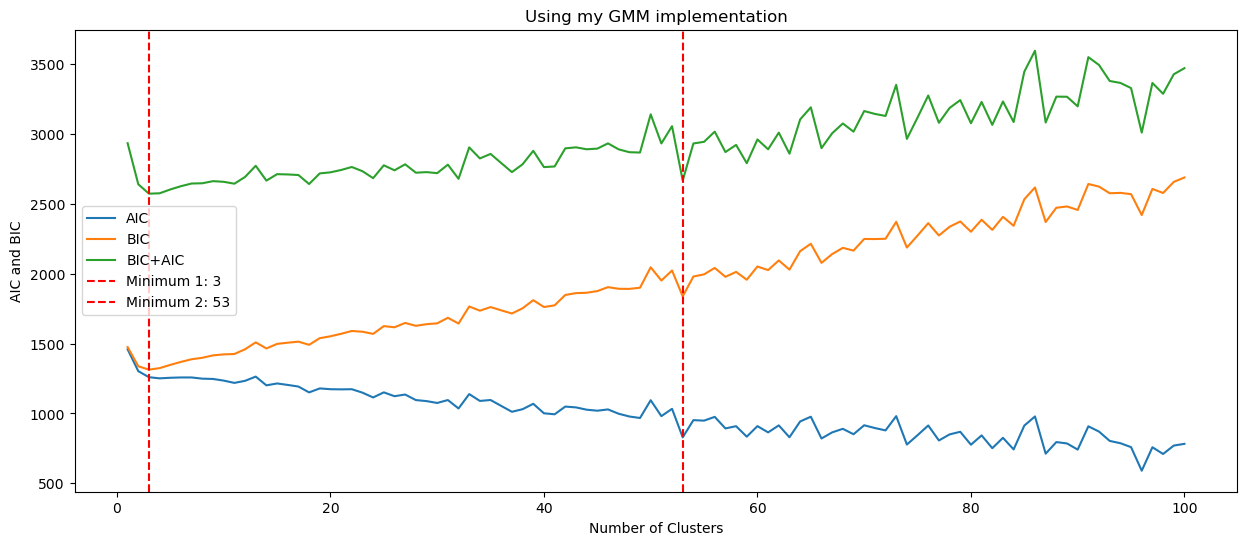

In [60]:
# plotting
plt.figure(figsize=(15, 6))

plt.plot(np.arange(1, num_clusters+1), aic_vals[1:], label='AIC')
plt.plot(np.arange(1, num_clusters+1), bic_vals[1:], label='BIC')
plt.plot(np.arange(1, num_clusters+1), (aic_vals[1:]+bic_vals[1:]), label='BIC+AIC')

plt.axvline(x = 3, color='red', linestyle='--', label='Minimum 1: 3')
plt.axvline(x = 53, color='red', linestyle='--', label='Minimum 2: 53')


plt.xlabel('Number of Clusters')
plt.ylabel('AIC and BIC')
plt.title('Using my GMM implementation')
plt.legend()

plt.show()

In [52]:
# using inbuilt GMM
from sklearn.mixture import GaussianMixture

builtin_aic_vals, builtin_bic_vals = [None], [None]

for num_clusters in range(1, max_clusters+1):
    print("--{}--".format(num_clusters), end = " ")
    my_gmm = GaussianMixture(n_components=num_clusters, random_state=42)
    my_gmm.fit(wine_data)
    builtin_aic_vals.append(my_gmm.aic(wine_data))
    builtin_bic_vals.append(my_gmm.bic(wine_data))

--1-- --2-- --3-- --4-- --5-- --6-- --7-- --8-- --9-- --10-- --11-- --12-- --13-- --14-- --15-- --16-- --17-- --18-- --19-- --20-- --21-- --22-- --23-- --24-- --25-- --26-- --27-- --28-- --29-- --30-- --31-- --32-- --33-- --34-- --35-- --36-- --37-- --38-- --39-- --40-- --41-- --42-- --43-- --44-- --45-- --46-- --47-- --48-- --49-- --50-- --51-- --52-- --53-- --54-- --55-- --56-- --57-- --58-- --59-- --60-- --61-- --62-- --63-- --64-- --65-- --66-- --67-- --68-- --69-- --70-- --71-- --72-- --73-- --74-- --75-- --76-- --77-- --78-- --79-- --80-- --81-- --82-- --83-- --84-- --85-- --86-- --87-- --88-- --89-- --90-- --91-- --92-- --93-- --94-- --95-- --96-- --97-- --98-- --99-- --100-- 

In [53]:
builtin_aic_vals = np.array(builtin_aic_vals)
builtin_bic_vals = np.array(builtin_bic_vals)

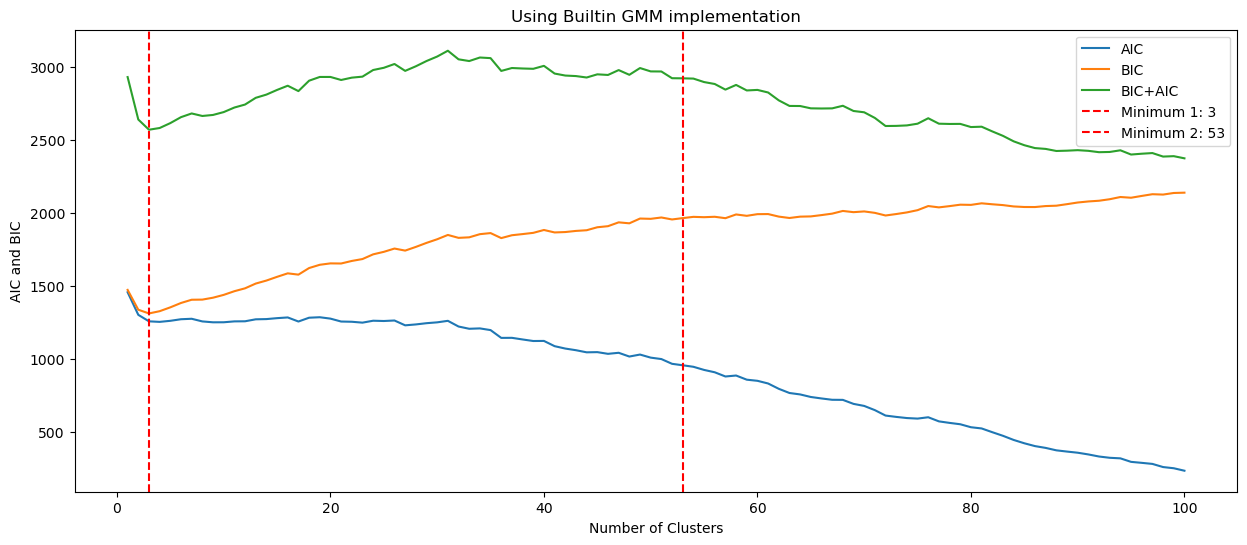

In [61]:
plt.figure(figsize=(15, 6))

plt.plot(np.arange(1, num_clusters+1), builtin_aic_vals[1:], label='AIC')
plt.plot(np.arange(1, num_clusters+1), builtin_bic_vals[1:], label='BIC')
plt.plot(np.arange(1, num_clusters+1), (builtin_aic_vals[1:]+builtin_bic_vals[1:]), label='BIC+AIC')

plt.axvline(x = 3, color='red', linestyle='--', label='Minimum 1: 3')
plt.axvline(x = 53, color='red', linestyle='--', label='Minimum 2: 53')

plt.xlabel('Number of Clusters')
plt.ylabel('AIC and BIC')
plt.title('Using Builtin GMM implementation')
plt.legend()

plt.show()

#### Conclusion
- As is clearly evident, my GMM is being calculated properly as a major dip in the AIC and BIC values is being observed at 3 clusters.
- Moreover, a decently low value is observed at 53 clusters as well. This can be be attributed to either threshold for stopping or maximum number of iterations.

Thus, we take the optimal number of clusters as $3$

In [62]:
optimal_cluster_num = 3

In [89]:
my_gmm = GMM(wine_data, num_clusters=3)
phis, means, covs = my_gmm.run()

means

array([[ 2.04701545, -0.37238595],
       [-0.68298981,  1.73379078],
       [-2.78110748, -1.27756872]])

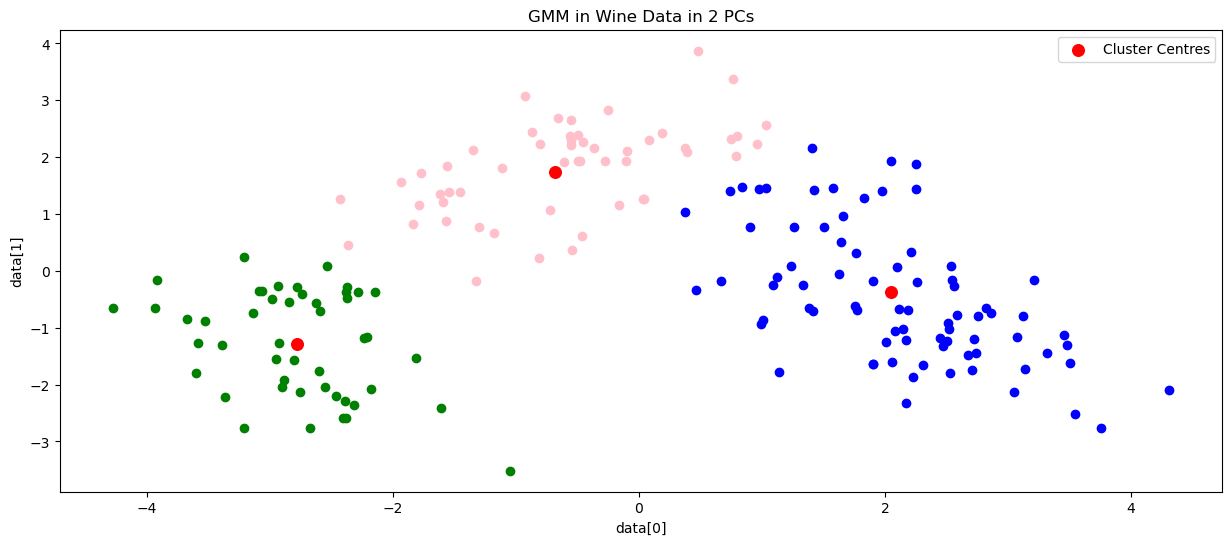

In [99]:
plt.figure(figsize=(15, 6))


my_gmm_labels = []
my_gmm_mem = my_gmm.get_membership()
for i in range(wine_data.shape[0]):
    color,label = 'green', 0
    if my_gmm_mem[i][0] >= my_gmm_mem[i][1] and my_gmm_mem[i][0] > my_gmm_mem[i][2]:
        color, label = 'blue', 1
    if my_gmm_mem[i][1] >= my_gmm_mem[i][0] and my_gmm_mem[i][1] > my_gmm_mem[i][2]:
        color, label = 'pink', 2
        
    plt.scatter(wine_data[i][0], wine_data[i][1], c = color)
    my_gmm_labels.append(label)

my_gmm_labels = np.array(my_gmm_labels)    

plt.scatter(means[:, 0], means[:, 1], color='red', s = 70, label='Cluster Centres')
plt.title('GMM in Wine Data in 2 PCs')
plt.xlabel('data[0]')
plt.ylabel('data[1]')
plt.legend()
plt.show()

In [82]:
# using K Means
from sklearn.cluster import KMeans

my_kmeans = KMeans(n_clusters=3, random_state=42)
my_kmeans.fit(wine_data)
kmeans_centers = my_kmeans.cluster_centers_
kmeans_cluster_labels = my_kmeans.labels_

kmeans_centers

/home/vineeth/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([[ 2.26614991, -0.86559213],
       [-2.74392982, -1.2141906 ],
       [-0.16278513,  1.76758824]])

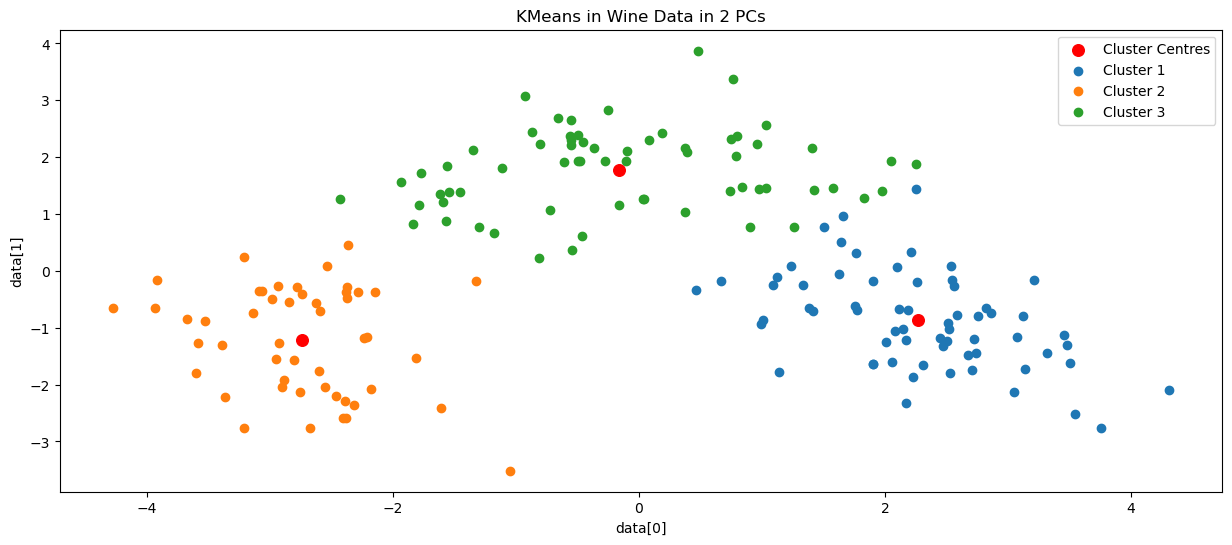

In [86]:
plt.figure(figsize=(15, 6))
plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], color='red', s = 70, label='Cluster Centres')

# this code has been taken from GPT "plot kmeans"
for cluster_id in range(3):
    plt.scatter(wine_data[kmeans_cluster_labels == cluster_id, 0], wine_data[kmeans_cluster_labels == cluster_id, 1], label=f'Cluster {cluster_id + 1}')

plt.title('KMeans in Wine Data in 2 PCs')
plt.xlabel('data[0]')
plt.ylabel('data[1]')
plt.legend()
plt.show()

#### Observations

- The means (cluster centers) come around to be pretty close in both GMMs and KMeans
- However, the size of clusters in KMeans is similar but differs in GMM (Since it also depends upon the covariance matrix)
- There exist overlapping between clusters (not shown but observed using membership values) in GMM, while in KMeans it is hard assignment.

#### Comparison of Silhoutte Scores

In [97]:
from sklearn.metrics import silhouette_score

In [101]:
# gmm
my_gmm_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1,
       1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 0, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [103]:
silhouette_gmm = silhouette_score(wine_data, my_gmm_labels)
print("\tSilhouette Score of GMM is {}\n\n".format(silhouette_gmm))

	Silhouette Score of GMM is 0.5319722918135587




In [104]:
# KMeans
kmeans_cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

In [105]:
silhouette_kmeans = silhouette_score(wine_data, kmeans_cluster_labels)
print("\tSilhouette Score of GMM is {}\n\n".format(silhouette_kmeans))

	Silhouette Score of GMM is 0.5610505693103246




$$Silhouette_{KMeans} > Silhoutte_{GMM}$$

A higher score indicates that points within a cluster are well matched to each other and separated from those in neighboring clusters.

So, KMeans has better inter-cluster and worse intra-cluster similarity.